In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import pandas as pd
import os 
import matplotlib.pyplot as plt
import math
import random
import torch.nn.functional as F

In [3]:
words=open('names.txt').read().splitlines()
chars=sorted(list(set(''.join(words))))
s_to_i={s:i+1 for i,s in enumerate(chars) }
s_to_i['.']=0
i_to_s={i:s for s,i in s_to_i.items()}
s_to_i

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [4]:
def build_dataset(words):
    context_length=3
    x,y=[],[]
    for w in words:
        # print(w)
        context=[0]*context_length
        for ch in w+'.':
            idx=s_to_i[ch]
            x.append(context)
            y.append(idx)
            # print(''.join(i_to_s[i] for i in context),'--->',i_to_s[idx])
            context=context[1:]+[idx]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return x,y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_val,y_val=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [124]:
# hyperparameters 
batch_size=64
emb_space=30
context_length=3
x_view=x_train.shape[1]*emb_space
h_units=300

In [126]:
#main model 
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,emb_space),generator=g)
w1=torch.randn((x_view,h_units),generator=g)   
b1=torch.randn((h_units),generator=g)
w2=torch.randn((h_units,27),generator=g)   
b2=torch.randn((27),generator=g) 

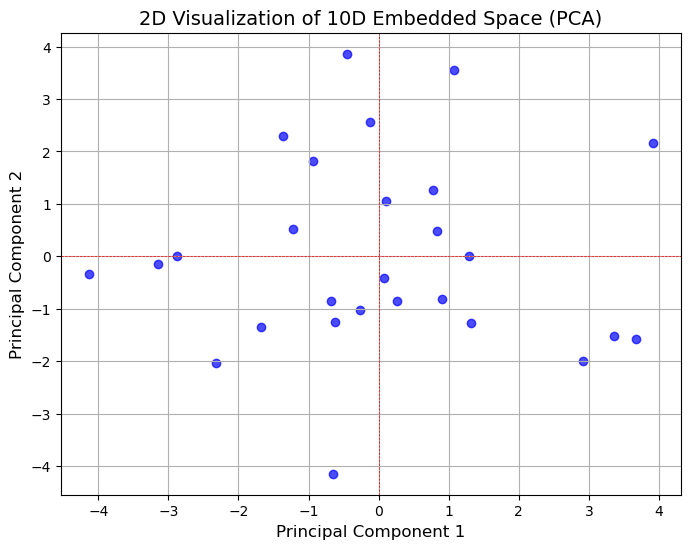

In [127]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
C_2d = pca.fit_transform(C.numpy())

# Plot the reduced 2D space
plt.figure(figsize=(8, 6))
plt.scatter(C_2d[:, 0], C_2d[:, 1], color='blue', alpha=0.7)
plt.grid('minor')
plt.axhline(0,color='red',linestyle='--',linewidth=0.5)
plt.axvline(0,color='red',linestyle='--',linewidth=0.5)
plt.title('2D Visualization of 10D Embedded Space (PCA)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

plt.grid(True)
plt.show()


In [128]:
parameters=[C,w1,w2,b1,b2]
for p in parameters:
    p.requires_grad=True
sum(p.nelement() for p in parameters)

36237

In [129]:
# how to decide a good leaarning rate 
lre=torch.linspace(-3,0,1000)
lrs=10**lre

# # thus we are takeing exponentially increasing lrs from 10e-3 to 10e-0 i.e 0.0001 to 1 
lossi=[]
steps=[]
lri=[]
lrex=[]

In [121]:

for i in range(1000):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,))  # batch size =32
    #foward pass
    emb=C[x_train[ix]]
    h= torch.tanh(emb.view(emb.shape[0],x_view) @ w1 + b1 )
    logits=(h @ w2)+ b2 
    loss=F.cross_entropy(logits,y_train[ix])
    if i%50==0:
        print(loss.item())
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    lr=lrs[i]
    for p in parameters:
        p.data+=-lr*p.grad

    # track stats
    lri.append(lr)
    lrex.append(lre[i])
    lossi.append(loss.item())






34.9251708984375
32.62031555175781
28.91486930847168
30.7403564453125
26.873043060302734
22.487831115722656
22.76512908935547
20.030092239379883
18.89069938659668
16.086469650268555
15.473648071289062
11.910989761352539
9.004936218261719
10.437912940979004
13.486343383789062
8.551475524902344
11.875441551208496
9.341883659362793
10.113850593566895
14.155415534973145


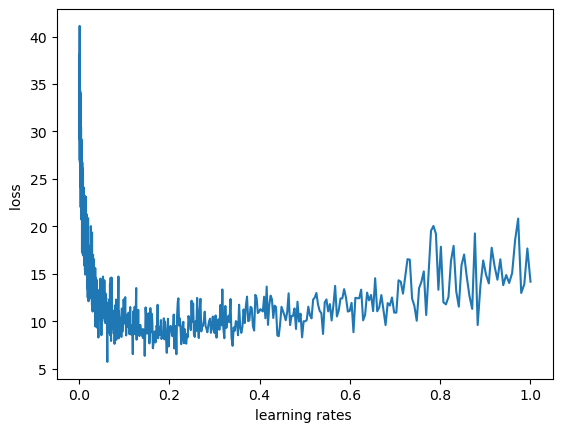

In [122]:
plt.plot(lri,lossi)
plt.xlabel('learning rates ')
plt.ylabel('loss ')
plt.show()

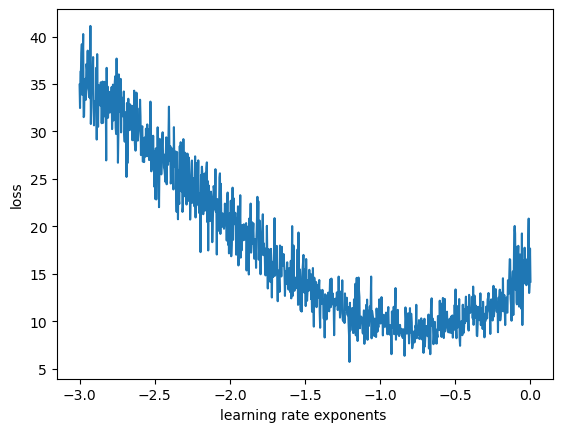

In [123]:
plt.plot(lrex,lossi)
plt.xlabel('learning rate exponents ')
plt.ylabel('loss')
plt.show()

In [130]:
for i in range(200000):
    #minibatch construct
    ix=torch.randint(0,x_train.shape[0],(batch_size,)) 
    #foward pass
    emb=C[x_train[ix]]
    h= torch.tanh(emb.view(emb.shape[0],x_view) @ w1 + b1 )
    logits=(h @ w2)+ b2 
    loss=F.cross_entropy(logits,y_train[ix])
    # if i%1000==0:
    #     print(loss.item())
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    lr=10**(-0.75) if i<100000 else 0.01
    for p in parameters:
            p.data+=-lr*p.grad

     # track stats
    steps.append(i)
    lossi.append(loss.log10().item())


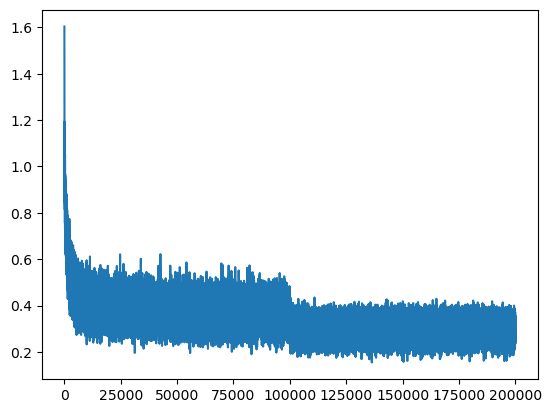

In [131]:
plt.plot(steps,lossi)

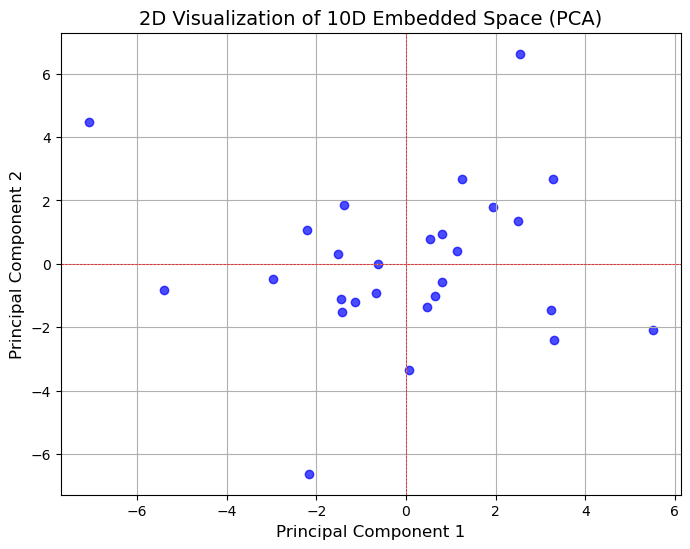

In [132]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
C_2d = pca.fit_transform(C.detach().numpy())

# Plot the reduced 2D space
plt.figure(figsize=(8, 6))
plt.scatter(C_2d[:, 0], C_2d[:, 1], color='blue', alpha=0.7)
plt.grid('minor')
plt.axhline(0,color='red',linestyle='--',linewidth=0.5)
plt.axvline(0,color='red',linestyle='--',linewidth=0.5)
plt.title('2D Visualization of 10D Embedded Space (PCA)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

plt.grid(True)
plt.show()


In [133]:

with torch.inference_mode():
    emb=C[x_train]
    h= torch.tanh(emb.view(emb.shape[0],x_view) @ w1 + b1 )
    logits=(h @ w2)+ b2
    loss=F.cross_entropy(logits,y_train)
loss


tensor(1.9970)

In [134]:

with torch.inference_mode():
    emb=C[x_val]
    h= torch.tanh(emb.view(emb.shape[0],x_view) @ w1 + b1 )
    logits=(h @ w2)+ b2
    loss=F.cross_entropy(logits,y_val)
loss


tensor(2.1268)

In [135]:
# sampling from the moodel 
g=torch.Generator().manual_seed(2147483647)
for i in range(20):
    out=[]
    context=[0]*context_length
    while True:
        emb=C[torch.tensor([context])] #(1,conntext_length,d)
        h= torch.tanh(emb.view(1,-1) @ w1 + b1 )
        logits=(h @ w2)+ b2
        probs=F.softmax(logits,dim=1)
        idx=torch.multinomial(probs,num_samples=1).item()
        context=context[1:]+[idx]
        out.append(idx)
        if idx==0:
            break
    print(''.join(i_to_s[i] for i in out))

baira.
keel.
yazeah.
aki.
milee.
kemina.
aleigh.
bestin.
miley.
cha.
elenishawn.
sari.
eliahni.
carekaus.
joel.
mice.
jamilian.
damolelindy.
mazilan.
car.


In [136]:

with torch.inference_mode():
    emb=C[x_test]
    h= torch.tanh(emb.view(emb.shape[0],x_view) @ w1 + b1 )
    logits=(h @ w2)+ b2
    loss=F.cross_entropy(logits,y_test)
loss

tensor(2.1311)

In [137]:
emb=C[x_train]
h= torch.tanh(emb.view(emb.shape[0],x_view) @ w1 + b1 )
logits=(h @ w2)+ b2
probs=F.softmax(logits,dim=1)
probs.shape
probs # joint probability distribution of every sequence

tensor([[1.6350e-04, 1.5922e-01, 3.4041e-02,  ..., 2.6725e-03, 1.3369e-02,
         3.2203e-02],
        [1.9015e-04, 5.1423e-01, 1.8400e-03,  ..., 3.5145e-06, 7.0196e-03,
         8.1962e-04],
        [1.1657e-03, 1.2468e-02, 1.4323e-02,  ..., 5.3337e-03, 1.0259e-03,
         1.7392e-03],
        ...,
        [3.1338e-01, 1.0626e-01, 4.4521e-04,  ..., 1.0701e-05, 7.6169e-02,
         1.5060e-07],
        [7.6823e-01, 9.7094e-04, 1.2196e-02,  ..., 8.2616e-04, 2.3716e-02,
         1.7554e-05],
        [3.6582e-01, 9.7078e-02, 1.4020e-04,  ..., 4.5935e-09, 4.4322e-02,
         2.7608e-05]], grad_fn=<SoftmaxBackward0>)

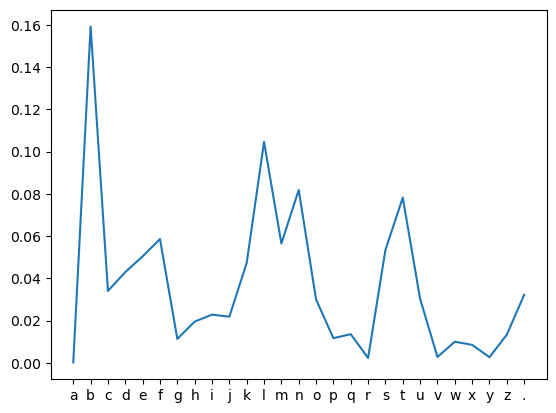

In [138]:
chars=sorted(list(set(''.join(words))))
s=chars.copy()
s=sorted(list(set(''.join(words))))
s.append('.')
p=(probs[0]).tolist()
plt.plot(s,p)           # probablity distribution of the first sequence 

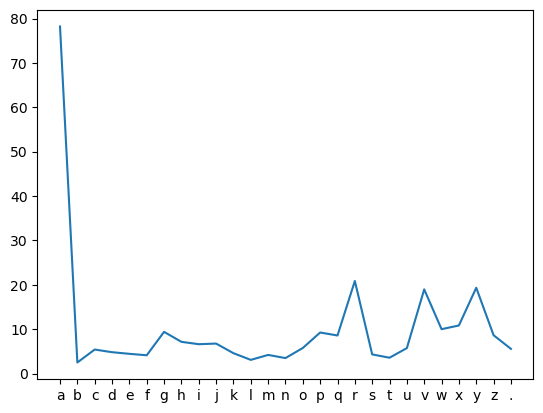

In [139]:
p=(torch.sqrt(1/probs[0])).tolist()
plt.plot(s,p)           # probablity distribution of the first sequence